# Gaussian Process Latent Variable Model (GP-LVM) for Dimensionality Reduction

A wide variety of dimensionality reduction problems can be solved with the Gaussian Process Latent Variable Model (GP-LVM). For this, we simply use a GP to map from a latent variable to an observed one - sampling from the latent will serve as input for the GP.

For reference see: http://jmlr.csail.mit.edu/papers/volume6/lawrence05a/lawrence05a.pdf


### Scientific value:

Coding this in practice is hard. We can show how to do this in Venture with
only a few lines of code.


### Deliverables

What currently does not work is gradient-based inference and multivariate input for GPs. For now, we only need to ensure that a GP can process input in  form of:

- scalars;

- 1- d arrays (to model vectors);

- multi-dimensional arrays (to model matrices);

a) **Multivariate input GPs.**

In the future, we should allow GPs to cope with all kinds of input that can be used for a covariance function. For now, we only focus on the three above.

=> Who is delivering this? Ulli with Taylor's help.


b) **Gradient-based inference.** For now, gradient ascent inference is sufficient.

=> Who is delivering this? Taylor with Ulli's help.

### Goal: Dimensionality Reduction

We want to perform dimensionality reduction using the Iris data set (Fig 1., below). Iris comes with four continous-valued features which we would like to map onto 2 latent components. According to this paper [Neal (2005)](http://jmlr.csail.mit.edu/papers/volume6/lawrence05a/lawrence05a.pdf) GP-LVM for likelihood optimization to find hyper-parameters in combination with independent GPs and linear kernels is equivalent to PCA. We therefore aim to produce a plot similar to Fig 3.

Currently multivariate input for GPs is not implemented. We therefore deploy a "fake"-GP (see program_part_4, below) that stubbs the GP-LVM program. The aim is (i) to allow multivariate input to GPs to (ii) perform gradient ascent to make Fig. 2 similar to Fig 3 (produced with Scikit Learn). Fig 2 is currently stubbed due to the fake GP.

In [1]:
from venture import shortcuts
import numpy as np
import pandas as pd
import seaborn as sns
import json
import codecs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline  

# Load Training Data

Load Iris dataset. This data set has four continuous valued variables and a name.

In [2]:
df = pd.read_csv("iris.csv")
df.iloc[0:5]

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


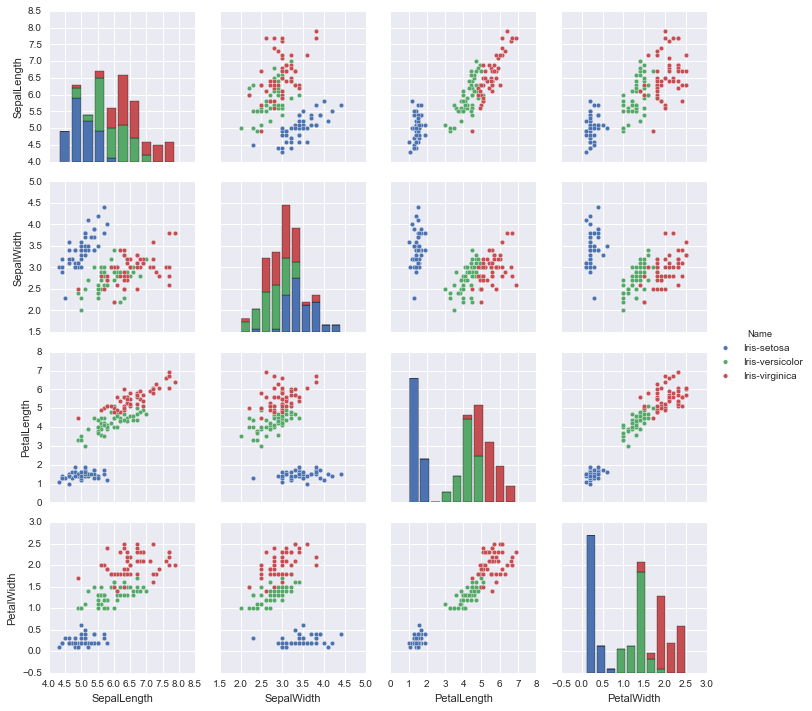

In [3]:
g = sns.pairplot(df, hue="Name")

Fig. 1: Visualizing the data.

# The Venture Program

In [4]:
ripl = shortcuts.make_lite_ripl()

Couldn't import dot_parser, loading of dot files will not be possible.


### Initialize the 2-diemsional latent lariable.

In [6]:
program_part_1 = """

assume latent_component_1 = mem(
    proc(data_index){
        normal(0,10)
        }
    );
        
assume latent_component_2 = mem(
    proc(data_index){
        normal(0,10)
        }
    );
        
assume latent_variable = mem(
            proc(data_index){
                list(
                   latent_component_1(data_index),
                   latent_component_2(data_index)
                )
                }
            );
"""
ripl.execute_program(program_part_1);

### Hyper-priors

In [7]:
program_part_2 = """
assume tolerance_constant = 00000.1;

// Indexed Hyper-parameters
assume noise_sigma = mem(
                        proc(gp_index){
                            tag("noise", gp_index, gamma(5,1))
                        }
                    );
                    
assume scale_factor = mem(
                        proc(gp_index){
                            tag("scale", gp_index, gamma(5,1))
                        }
                    );
                    
assume offset = mem(
                        proc(gp_index){
                            tag("off", gp_index, gamma(5,1))
                        }
                    );
"""
ripl.execute_program(program_part_2);

### Covariance Kernels

In [8]:
program_part_3= """
assume noise_kernel = proc(gp_index){
    gp_cov_scale(
            noise_sigma(gp_index),
            gp_cov_delta(tolerance_constant)
            )
    };
    
assume linear_kernel = proc(gp_index){
    gp_cov_scale(
        scale_factor(gp_index),
        gp_cov_linear(offset(gp_index))
        )
    };

assume covariance_kernel = proc(gp_index){
    gp_cov_sum(
        linear_kernel(gp_index),
        noise_kernel(gp_index)
        )
    };

assume zero_mean_function =gp_mean_const(0.);
"""
ripl.execute_program(program_part_3);

We define a `fake_gp`- which ignores input covariance function and mean function and outputs a sample from a multivariate normal where the length of the sample is determined by the input to `fake_gp`. We do this because currently, multivariate input breaks the GP implementation - thus we stub the actual gp ( `make_gp` ) to generate plots and results. 

In [9]:
program_part_4 = """
assume fake_gp = proc(mean_function, covariance_function){
    proc(x){
        zeros = fill(size(lookup(x,0)), 0);
        ones  = fill(size(lookup(x,0)), 1);
        
        multivariate_normal(zeros,diag_matrix(ones))    
    }
};
"""
ripl.execute_program(program_part_4);

We call 4 indepedent GPs that map from the 2 dimensional latent variable onto the observed output.

In [10]:
program_part_5 = """
// independent GPs for each observed dimension
assume gp1 = fake_gp(zero_mean_function, covariance_kernel(1));
assume gp2 = fake_gp(zero_mean_function, covariance_kernel(2));
assume gp3 = fake_gp(zero_mean_function, covariance_kernel(3));
assume gp4 = fake_gp(zero_mean_function, covariance_kernel(4));
"""
ripl.execute_program(program_part_5);

# Make Observations

In [11]:
for i in range(len(df.index)):
    ripl.execute_program("observe gp1(array(x(%i))) = array(%d)"  % (i,df.iloc[i]["SepalLength"]))
    ripl.execute_program("observe gp2(array(x(%i))) = array(%d)"  % (i,df.iloc[i]["SepalWidth"]))
    ripl.execute_program("observe gp3(array(x(%i))) = array(%d)"  % (i,df.iloc[i]["PetalLength"]))
    ripl.execute_program("observe gp4(array(x(%i))) = array(%d)"  % (i,df.iloc[i]["PetalWidth"]))

Trying to annotate an exception led to:
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/ripl/ripl.py", line 185, in _raise_annotated
    annotated = self._annotated_error(e, instruction)
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/ripl/ripl.py", line 198, in _annotated_error
    exp, text_index = self.humanReadable(**frame)
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/ripl/ripl.py", line 422, in humanReadable
    if hasattr(sys.stdout, "fileno") and os.isatty(sys.stdout.fileno()):
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/iostream.py", line 306, in fileno
    raise UnsupportedOperation("IOStream has no fileno.")
UnsupportedOperation: IOStream has no fileno.

Trying to annotate an exception led to:
Traceback (most recent call last):
  File

VentureException: *** evaluation: Nested ripl operation signalled an error
{'stack_trace': [{'did': 60, 'index': [1], 'exp': [{'type': 'symbol', 'value': 'autorun'}, [{'type': 'symbol', 'value': 'observe'}, [{'type': 'symbol', 'value': 'gp1'}, [{'type': 'symbol', 'value': 'array'}, [{'type': 'symbol', 'value': 'x'}, {'type': 'number', 'value': 0}]]], [{'type': 'symbol', 'value': 'array'}, {'type': 'number', 'value': 5}]]]}], 'cause': VentureNestedRiplMethodError('Nested ripl operation signalled an error',)}
Caused by
*** evaluation: Cannot find symbol 'x'
{'stack_trace': [{'did': 61, 'index': [1, 1, 0], 'exp': {'type': 'array', 'value': [{'type': 'symbol', 'value': 'gp1'}, {'type': 'array', 'value': [{'type': 'symbol', 'value': 'array'}, {'type': 'array', 'value': [{'type': 'symbol', 'value': 'x'}, {'type': 'number', 'value': 0.0}]}]}]}}]}
**************************************************
Stack trace from worker:
**************************************************
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/multiprocess.py", line 104, in wrapped
    res = f(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/multiprocess.py", line 341, in <lambda>
    return safely(lambda *args,**kwargs: getattr(self.obj, attrname)(*args, **kwargs))
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/engine/trace.py", line 62, in observe
    self.trace.eval(baseAddr, exp)
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/lite/trace.py", line 385, in eval
    Scaffold(), False, OmegaDB(), {})
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/lite/regen.py", line 195, in evalFamily
    shouldRestore, omegaDB, gradients)
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/lite/regen.py", line 195, in evalFamily
    shouldRestore, omegaDB, gradients)
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/lite/regen.py", line 195, in evalFamily
    shouldRestore, omegaDB, gradients)
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/lite/regen.py", line 176, in evalFamily
    sourceNode = env.findSymbol(exp)
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/lite/env.py", line 63, in findSymbol
    else: ret = self.outerEnv.findSymbol(sym)
  File "/usr/local/lib/python2.7/dist-packages/venture-0.5.post601_gd421d4f.dirty-py2.7-linux-x86_64.egg/venture/lite/env.py", line 65, in findSymbol
    raise VentureError("Cannot find symbol '%s'" % sym)
VentureException: *** evaluation: Cannot find symbol 'x'
{'address': [[61, 1, 1, 0]]}


Inference does not work

In [ ]:
ripl.infer("""mh(default, one, 100)""")

## What we need to get to run 

In [ ]:
#ripl.infer("grad_ascent(default, all, 0.05, 100, 1)")

In [ ]:
latent_sample1 = []
latent_sample2 = []
for i in range(len(df.index)):
    current_latent_sample = ripl.sample("x(%i)" % (i,))
    latent_sample1.append(current_latent_sample[0])
    latent_sample2.append(current_latent_sample[1])
    
latent_sample1 = np.array(latent_sample1)
latent_sample2 = np.array(latent_sample2)

# Plotting Loading of Latent Components

Below, we plot the two latent components and color datapoints according to their species (i.e. Iris name).

In [ ]:
plt.scatter(latent_sample1[np.array(df["Name"]=="Iris-virginica")],latent_sample2[np.array(df["Name"]=="Iris-virginica")], color="red", label= "Iris-virginica")
plt.scatter(latent_sample1[np.array(df["Name"]=="Iris-versicolor")],latent_sample2[np.array(df["Name"]=="Iris-versicolor")], color="green", label= "Iris-versicolor")
plt.scatter(latent_sample1[np.array(df["Name"]=="Iris-setosa")],latent_sample2[np.array(df["Name"]=="Iris-setosa")], color="blue", label= "Iris-setosa")
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")
plt.legend()

# PCA with SciKit learn (comparison)

Below, we run a simple (out-of-the-box) PCA to compare the results.

In [ ]:
df = pd.read_csv("iris.csv")
pca = PCA(n_components=2)
pca.fit(np.array(df.drop("Name", axis=1))) 
sk_latent = np.dot(np.array(df.drop("Name", axis=1)),pca.components_.T)

In [ ]:
plt.scatter(sk_latent[:,0][np.array(df["Name"]=="Iris-virginica")],sk_latent[:,1][np.array(df["Name"]=="Iris-virginica")], color="red", label= "Iris-virginica")
plt.scatter(sk_latent[:,0][np.array(df["Name"]=="Iris-versicolor")],sk_latent[:,1][np.array(df["Name"]=="Iris-versicolor")], color="green", label= "Iris-versicolor")
plt.scatter(sk_latent[:,0][np.array(df["Name"]=="Iris-setosa")],sk_latent[:,1][np.array(df["Name"]=="Iris-setosa")], color="blue", label= "Iris-setosa")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
#ax = sns.kdeplot(sk_latent[:,0][np.array(df["Name"]=="Iris-versicolor")],sk_latent[:,1][np.array(df["Name"]=="Iris-versicolor")], cmap="Greens")
#ax = sns.kdeplot(sk_latent[:,0][np.array(df["Name"]=="Iris-setosa")],sk_latent[:,1][np.array(df["Name"]=="Iris-setosa")], cmap="Blues")
#ax = sns.kdeplot(sk_latent[:,0][np.array(df["Name"]=="Iris-versicolor")], latent_sample2[np.array(df["Name"]=="Iris-versicolor")],  cmap="Greens")
#ax = sns.kdeplot(sk_latent[:,0][np.array(df["Name"]=="Iris-setosa")], latent_sample2[np.array(df["Name"]=="Iris-setosa")],  cmap="Blues")

Fig. 2: Principal Component Analysis. We plot the 2 latent components and color by Iris species.